# Neural Style Transfer

This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 



In [30]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 


<img src="images/NN_Transfer_out.jpg" style="width:750px;height:200px;">



## 3 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost



In [5]:


def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,[n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G,[n_H*n_W,n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
   
    
    return J_content

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


### 3.2 - Computing the style cost



In [9]:


def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    
    GA = tf.matmul(A,tf.transpose(A))
 
    
    return GA

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


**Expected Output**:

<table>
    <tr>
        <td>
            **GA**
        </td>
        <td>
           [[  6.42230511  -4.42912197  -2.09668207] <br>
 [ -4.42912197  19.46583748  19.56387138] <br>
 [ -2.09668207  19.56387138  20.6864624 ]]
        </td>
    </tr>

</table>

### 3.2.2 - Style cost

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


In [11]:


def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    

    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S,[n_H*n_W,n_C])
    a_G = tf.reshape(a_G,[n_H*n_W,n_C])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*tf.square(tf.to_float(n_H*n_W*n_C)))
    
    
    
    return J_style_layer

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


### 3.2.3 Style Weights



In [13]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [14]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize

In [15]:


def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    
    J = (alpha*J_content)+(beta*J_style)
    
    
    return J

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


## 4 - Solving the optimization problem





<font color='purple'>

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>


In [17]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [18]:

content_image = scipy.misc.imread("images/IMG_3514.JPG")
#content_image=tf.reshape(content_image,[300,400,3])

content_image = reshape_and_normalize_image(content_image)

print(content_image.shape)
#


(1, 300, 400, 3)


In [19]:
style_image = scipy.misc.imread("images/Starry_Night.jpg")
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)




(1, 300, 400, 3)


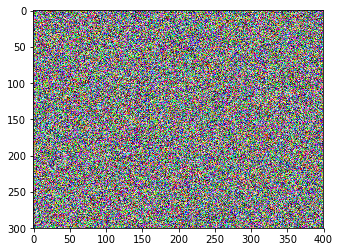

In [20]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [21]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [22]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [23]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [24]:

J = total_cost(J_content, J_style, alpha = 10, beta = 40)


In [25]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [26]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    
    sess.run(tf.global_variables_initializer())
    
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    
    sess.run(model['input'].assign(input_image))
    
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        
        _ = sess.run(train_step)
        
        
        # Compute the generated image by running the session on the current model['input']
        
        generated_image = sess.run(model['input'])
        

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [27]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 3.09729e+10
content cost = 10768.4
style cost = 7.7432e+08
Iteration 20 :
total cost = 3.96253e+09
content cost = 29746.4
style cost = 9.90559e+07
Iteration 40 :
total cost = 1.23181e+09
content cost = 32581.7
style cost = 3.07872e+07
Iteration 60 :
total cost = 7.35401e+08
content cost = 33479.4
style cost = 1.83767e+07
Iteration 80 :
total cost = 5.25422e+08
content cost = 33990.7
style cost = 1.31271e+07
Iteration 100 :
total cost = 4.00833e+08
content cost = 34359.5
style cost = 1.00122e+07
Iteration 120 :
total cost = 3.15309e+08
content cost = 34655.8
style cost = 7.87406e+06
Iteration 140 :
total cost = 2.54467e+08
content cost = 34913.7
style cost = 6.35295e+06
Iteration 160 :
total cost = 2.10464e+08
content cost = 35119.0
style cost = 5.25281e+06
Iteration 180 :
total cost = 1.78029e+08
content cost = 35282.2
style cost = 4.4419e+06


array([[[[   8.75643158,   51.87491989,   80.67121124],
         [  19.20723152,  -94.49214172,   24.73638535],
         [  -0.35851622,  -85.66370392,   -7.3298502 ],
         ..., 
         [  51.53662109,   12.25614929,  -60.68347931],
         [  38.15014267,   18.1795578 ,  -59.70138931],
         [   2.14632487,   13.41330719,  -38.30134201]],

        [[   6.34211493,  -47.46309662,   62.80834961],
         [   8.42657661, -100.45066071,  -66.206604  ],
         [   8.05297279, -100.20617676,  -62.40587234],
         ..., 
         [  57.06048965,   47.65091324,  -41.86582184],
         [  65.91593933,   11.06937504,  -76.34767151],
         [  43.78515244,   16.81280136,  -60.42734146]],

        [[   6.05220509,  -79.5657196 ,   79.3290863 ],
         [   2.5904181 , -108.67193604,  -82.00396729],
         [  -3.37149405,  -91.69975281,  -77.93382263],
         ..., 
         [  81.27915955,   41.74741364,  -32.88759232],
         [  80.57326508,   46.24775696,  -46.32685471],

### Output
<img src="images/NN_Transfer_out.jpg" style="width:800px;height:300px;">



### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
